# my attempt at recreating this https://www.youtube.com/watch?v=UhHSX5CahkU&t=513s

In [71]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from ipywidgets import interact
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import socket
import seaborn as sns

In [57]:
df = pd.read_csv('Input_data/pokemon_all_gen.csv')
df.head(13)

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,3,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,309,39,52,43,60,50,65
5,5,Charmeleon,Fire,405,58,64,58,80,65,80
6,6,Charizard,Fire Flying,534,78,84,78,109,85,100
7,6,Charizard Mega Charizard X,Fire Dragon,634,78,130,111,130,85,100
8,6,Charizard Mega Charizard Y,Fire Flying,634,78,104,78,159,115,100
9,7,Squirtle,Water,314,44,48,65,50,64,43


# keep only pokemon stats as numeric columns for PCA

In [60]:
names = df['Name']
df = df.set_index('Name')
cols = df.columns.to_list()
# we do not keep the Total Stats since that number is redudant for PCA
stats_cols = cols[-6:]
X = df[stats_cols]
X.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Name,,,,,,
Bulbasaur,45,49,49,65,65,45
Ivysaur,60,62,63,80,80,60
Venusaur,80,82,83,100,100,80
Venusaur Mega Venusaur,80,100,123,122,120,80
Charmander,39,52,43,60,50,65


# Standarize the data so mean = 0 and var = 1

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[-0.97774967 -1.00690929 -0.84919009 -0.25465702 -0.27376568 -0.83301891]
 [-0.41978972 -0.60147972 -0.39332906  0.20252547  0.26951688 -0.33546066]
 [ 0.32415688  0.02225808  0.25790099  0.81210212  0.99389362  0.32795034]
 ...
 [ 0.88211683  0.42768764  1.13706155  0.96449628  1.35608199  0.49380309]
 [ 3.29994327  0.73955654  1.13706155  1.7264671   1.35608199  0.49380309]
 [ 0.62173552  0.20937941  2.76513667  0.44635613  0.55926757  0.59331474]]


# do the PCA fit

In [54]:
# Choose the number of components you want
n_components = X.shape[1]
pca = PCA(n_components=n_components)

# Fit PCA
X_pca = pca.fit_transform(X_scaled)

# Convert back to DataFrame
Y = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)], index=names)
Y.head()

,PC1,PC2,PC3,PC4,PC5,PC6
Name,,,,,,
Bulbasaur,-1.667552,-0.009134,-0.767622,0.057528,0.259917,-0.289447
Ivysaur,-0.485119,0.064793,-0.785405,0.093646,0.108885,-0.204629
Venusaur,1.144803,0.138220,-0.755176,0.103783,-0.066508,-0.108665
Venusaur Mega Venusaur,2.519029,-0.512658,-1.072197,-0.544287,0.282299,0.069008
Charmander,-1.902704,0.652201,-0.318952,-0.240846,0.148994,-0.044639


# look at fraction of variance explained by components

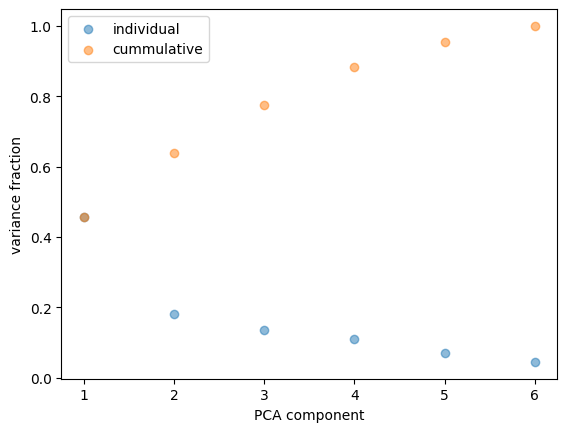

Explained variance ratio: [0.45777848 0.18107699 0.13619948 0.10881608 0.07122844 0.04490054]
[0.45777848 0.63885547 0.77505495 0.88387102 0.95509946 1.        ]


In [55]:
x = np.arange(1, n_components+1,1)
# print(x)

plt.plot()
plt.scatter(x, var_pca, label='individual', alpha=0.5)
plt.scatter(x, cum_sum, label='cummulative', alpha=0.5)
plt.xlabel('PCA component')
plt.ylabel('variance fraction')
plt.legend()
plt.show()

var_pca = pca.explained_variance_ratio_
print("Explained variance ratio:", var_pca)
cum_sum = np.cumsum(var_pca)
print(cum_sum)


# visualize the PCA components

In [68]:
# Loadings: how each original feature contributes to each PC
loadings = pd.DataFrame(
    pca.components_.T,   # shape (n_features, n_components)
    index=X.columns,     # original features
    columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)]
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
HP,0.412886,-0.136652,0.274954,0.792612,-0.260161,0.198330
Attack,0.435270,-0.003791,0.643402,-0.223251,0.311837,-0.499476
Defense,0.394930,-0.571831,0.009926,-0.448073,0.001163,0.562290
Sp. Atk,0.428920,0.334638,-0.426775,0.162442,0.681927,0.174630
Sp. Def,0.452659,-0.177185,-0.559053,-0.066361,-0.393466,-0.540320
Speed,0.308583,0.714803,0.125136,-0.300607,-0.463932,0.269401


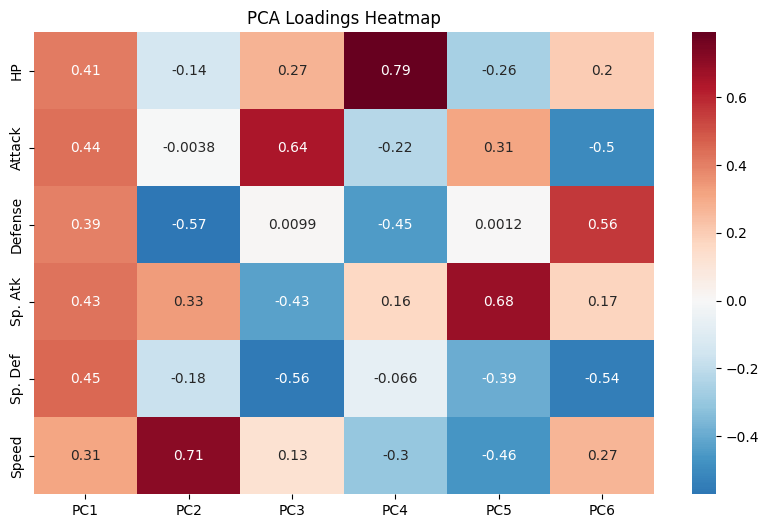

In [72]:
plt.figure(figsize=(10,6))
sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0)
plt.title("PCA Loadings Heatmap")
plt.show()

It its clear to see PC1 is almost an equal mix of each stat, which is basically the total stats of a pokemon. So the total stats are a good predictor of a pokemons value. PC2 is high speed and good sp atk, with low defense signaling an aggressive pokemon. PC3 has high regular attack and super low defense, showing yet another aggressive trait.

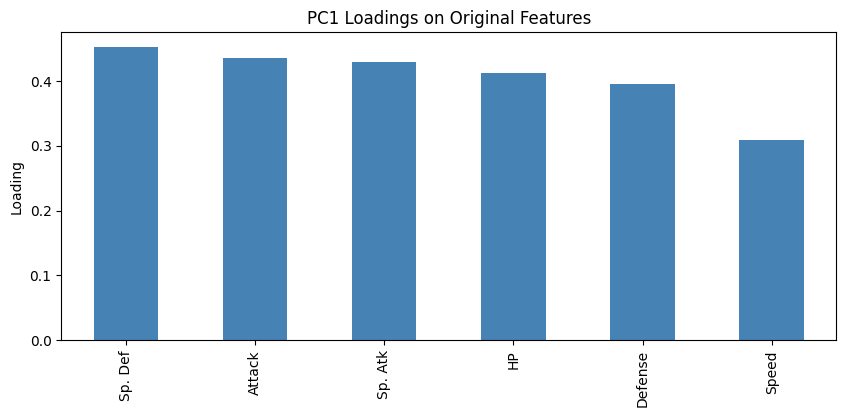

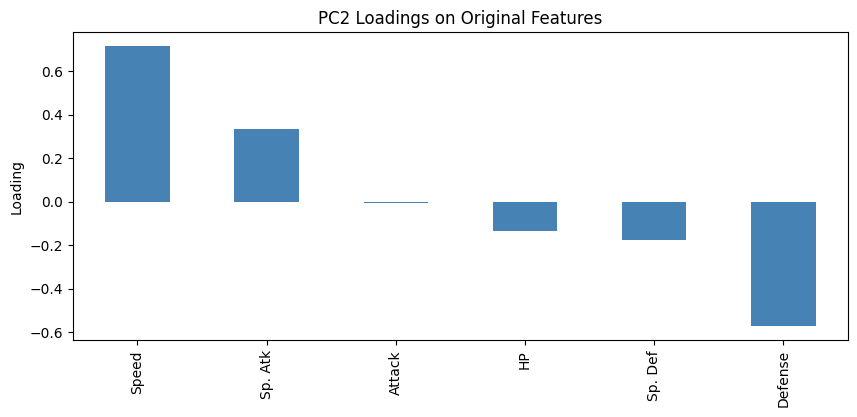

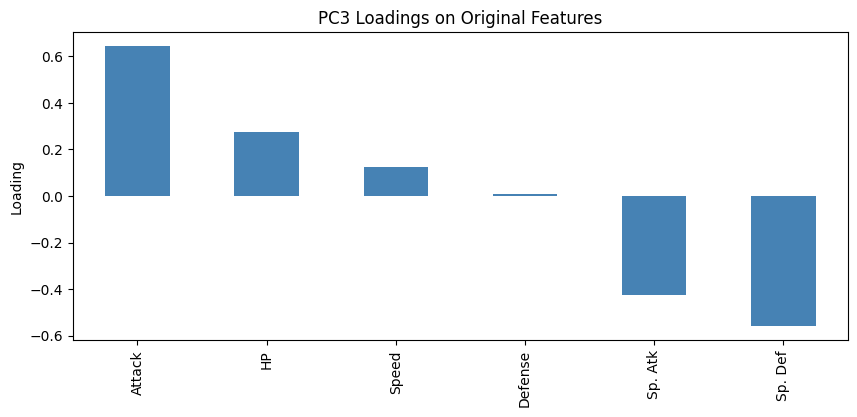

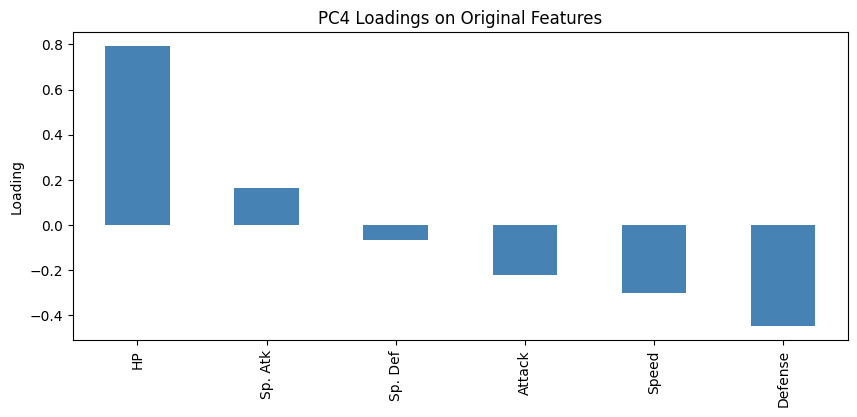

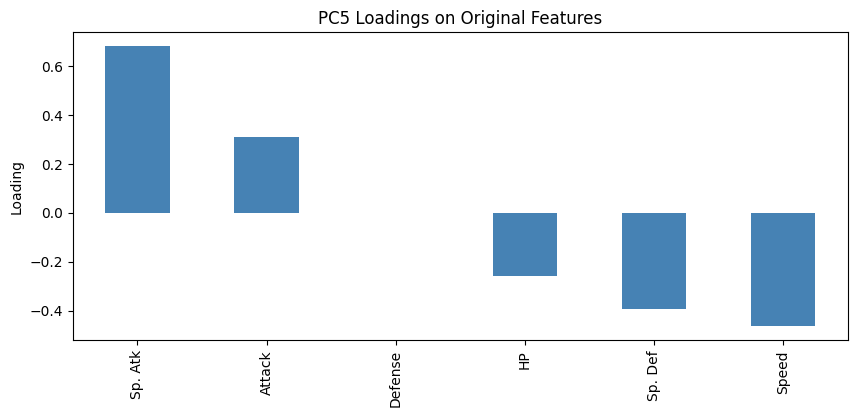

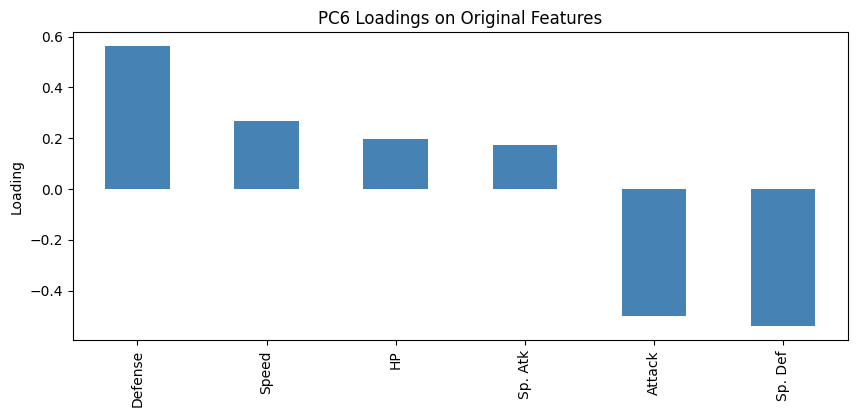

In [79]:
for i in range(6):
    label = 'PC' + str(i+1)
    loadings[label].sort_values(ascending=False).plot(kind='bar', figsize=(10,4), color='steelblue')
    plt.ylabel("Loading")
    plt.title(label + " Loadings on Original Features")
    plt.show()


# compare PCA 1 and PCA 2 values

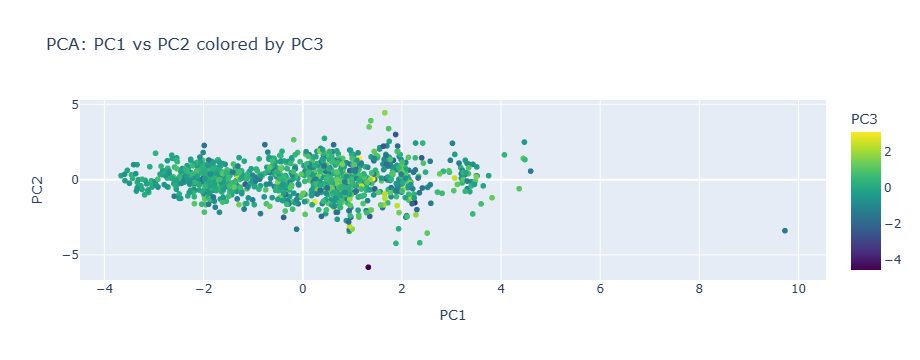

In [48]:
fig = px.scatter(
    df_pca,
    x='PC1',
    y='PC2',
    color='PC3',             # Color points by PC3
    hover_data=[df_pca.index],  # show index on hover
    title='PCA: PC1 vs PC2 colored by PC3',
    color_continuous_scale='Viridis'  # optional color scale
)

fig.show()

# interactive scatter chart choosing from different PCA components 

In [59]:
# Assume df_pca has columns PC1, PC2, ..., PC6
pc_cols = [f'PC{i}' for i in range(1, 7)]

def interactive_pca_plot(x_axis='PC1', y_axis='PC2', color='PC3'):
    fig = px.scatter(
        df_pca,
        x=x_axis,
        y=y_axis,
        color=color,
        hover_data=[df_pca.index],
        color_continuous_scale='Viridis',  # optional color scale
        title=f'PCA: {x_axis} vs {y_axis} colored by {color}'
    )
    fig.show()

# Create interactive widgets
interact(
    interactive_pca_plot,
    x_axis=pc_cols,
    y_axis=pc_cols,
    color=pc_cols
)

interactive(children=(Dropdown(description='x_axis', options=('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'), value…

<function __main__.interactive_pca_plot(x_axis='PC1', y_axis='PC2', color='PC3')>

# Fancier Version of PC scatter chart

In [66]:
# Function to find a free port
def find_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('', 0))  # bind to a free port assigned by the OS
    port = s.getsockname()[1]
    s.close()
    return port

# Assume df_pca is your PCA DataFrame with columns PC1, PC2, ..., PC6
pc_cols = [f'PC{i}' for i in range(1, 7)]
hover_labels = df_pca.index  # or df['Name'] if you have labels

color_options = pc_cols  # or include categorical columns

# Initialize Dash app
app = Dash(__name__)

# Layout
app.layout = html.Div([
    html.H2("Interactive PCA Explorer"),
    
    html.Div([
        html.Label("X-axis:"),
        dcc.Dropdown(id='x-axis', options=[{'label': c, 'value': c} for c in pc_cols], value='PC1')
    ], style={'width':'30%', 'display':'inline-block'}),
    
    html.Div([
        html.Label("Y-axis:"),
        dcc.Dropdown(id='y-axis', options=[{'label': c, 'value': c} for c in pc_cols], value='PC2')
    ], style={'width':'30%', 'display':'inline-block', 'marginLeft':'20px'}),
    
    html.Div([
        html.Label("Color:"),
        dcc.Dropdown(id='color', options=[{'label': c, 'value': c} for c in color_options], value='PC3')
    ], style={'width':'30%', 'display':'inline-block', 'marginLeft':'20px'}),
    
    dcc.Graph(id='pca-scatter', style={'height': '600px'})
])

# Callback to update scatter plot
@app.callback(
    Output('pca-scatter', 'figure'),
    [Input('x-axis', 'value'),
     Input('y-axis', 'value'),
     Input('color', 'value')]
)
def update_scatter(x_axis, y_axis, color):
    fig = px.scatter(
        df_pca,
        x=x_axis,
        y=y_axis,
        color=color,
        hover_data=[hover_labels],
        color_continuous_scale='Viridis',
        title=f'PCA: {x_axis} vs {y_axis} colored by {color}'
    )
    fig.update_layout(transition_duration=300)
    return fig

# Run app in notebook with a free port
free_port = find_free_port()
app.run(mode='inline', port=free_port)